In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
%run ./processing.ipynb
%run ./utils.ipynb
%run ./EFA.ipynb

In [3]:
file="HCPData.xlsx"
dic_file="HCP_S1200_DataDictionary_April_20_2018.xlsx"
ttl=pd.read_excel(file)

dic=pd.read_excel(dic_file)

In [4]:
print(ttl.shape)
ttl.describe()

(1206, 582)


,Subject,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,3T_tMRI_PctCompl,fMRI_WM_PctCompl,fMRI_Gamb_PctCompl,fMRI_Mot_PctCompl,fMRI_Lang_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
count,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,...,1196.000000,1204.000000,1204.000000,1201.000000,1205.000000,1200.000000,1200.000000,1198.000000,1195.000000,1195.000000
mean,374551.585406,1.478441,1.400498,3.509950,87.213267,88.219569,89.718076,89.852736,89.631675,87.027114,...,4.404682,110.421321,97.727500,1.449625,45.847718,95.166983,93.998533,1.845467,0.581590,1.822251
std,272686.898230,0.635688,0.628216,1.215181,31.027886,29.942161,30.384864,30.163559,30.492092,33.566043,...,1.513823,9.107963,11.273251,1.783069,7.679288,14.583412,14.837851,0.541393,0.973172,0.542893
min,100004.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.400000,82.740000,59.860000,0.000000,38.600000,56.350000,59.500000,1.560000,0.000000,1.080000
25%,154254.250000,1.000000,1.000000,4.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,3.600000,101.120000,87.110000,0.000000,38.600000,84.070000,83.220000,1.800000,0.000000,1.760000
50%,212166.500000,2.000000,1.000000,4.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,4.400000,108.790000,98.040000,1.000000,45.900000,95.360000,94.970000,1.800000,0.000000,1.800000
75%,586310.500000,2.000000,2.000000,4.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,5.200000,122.250000,110.450000,2.000000,52.200000,105.570000,102.920000,1.880000,1.000000,1.840000
max,996782.000000,2.000000,2.000000,4.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,14.000000,122.250000,111.410000,10.000000,75.300000,134.650000,131.380000,15.000000,17.000000,15.000000


# Variable selection:

In [5]:
cog_vars = dic[(dic['category'] == 'Cognition')| (dic['assessment'].isin(['Working Memory', 'Language']))]
cogList=ttl[cog_vars['columnHeader']]
#Variables filter
missingValue_mask = cogList.isnull().mean() < 0.15 #more than 15% of the data is missing
non_boolean_mask = ~(cogList.dtypes == 'bool')
#removing age adjusted variables
adj_mask = ~(cogList.columns.str.contains('AgeAdj')) 

selected_columns = cogList.loc[:, adj_mask & missingValue_mask & non_boolean_mask].columns.tolist()
short_df = cogList[selected_columns].copy()
print(short_df.shape)
print(short_df.info())

(1206, 103)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1206 entries, 0 to 1205
Columns: 103 entries, PicSeq_Unadj to WM_Task_2bk_Tool_Median_RT_Nontarget
dtypes: float64(103)
memory usage: 970.6 KB
None


In [6]:
#droppoing comulative scores
#Cumulative measures were excluded as they are an average of the tasks scores. 
short_df.drop(["CogFluidComp_Unadj","CogEarlyComp_Unadj","CogTotalComp_Unadj","CogCrystalComp_Unadj"], axis=1, inplace=True)

Short Penn Continuous Performance Test:

In [7]:
#including sensitivity and specificity only as summary score
short_df.drop(["SCPT_TP","SCPT_TN","SCPT_FP","SCPT_FN","SCPT_LRNR"], axis=1, inplace=True)

Penn Progressive Matrices:

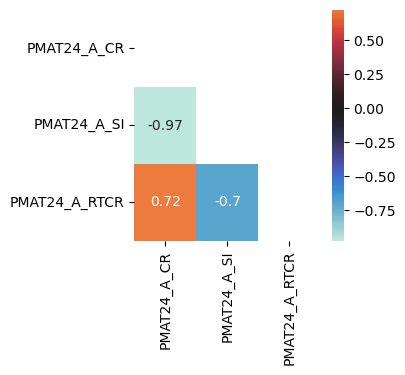

In [8]:
c=short_df.loc[:,'PMAT24_A_CR':'PMAT24_A_RTCR'].corr()
mask = np.triu(np.ones_like(c, dtype=bool))
f, ax = plt.subplots(figsize=(3,3))
sns.heatmap(c, annot=True, center=0, mask=mask)
plt.show()

In [9]:
#excluding skipped items score as it is highly correlated with the correct response score  (>0.95)
short_df.drop(['PMAT24_A_SI','PMAT24_A_RTCR'],axis=1, inplace=True)

print(short_df.shape)

(1206, 92)


In [10]:
#Self-regulation measures were excluded as they were not correlated with any of the other measures
short_df.drop(columns=short_df.loc[:, 'DDisc_SV_1mo_200':'DDisc_AUC_40K'].columns, inplace=True)

print(short_df.shape)

(1206, 78)


Language_Task:

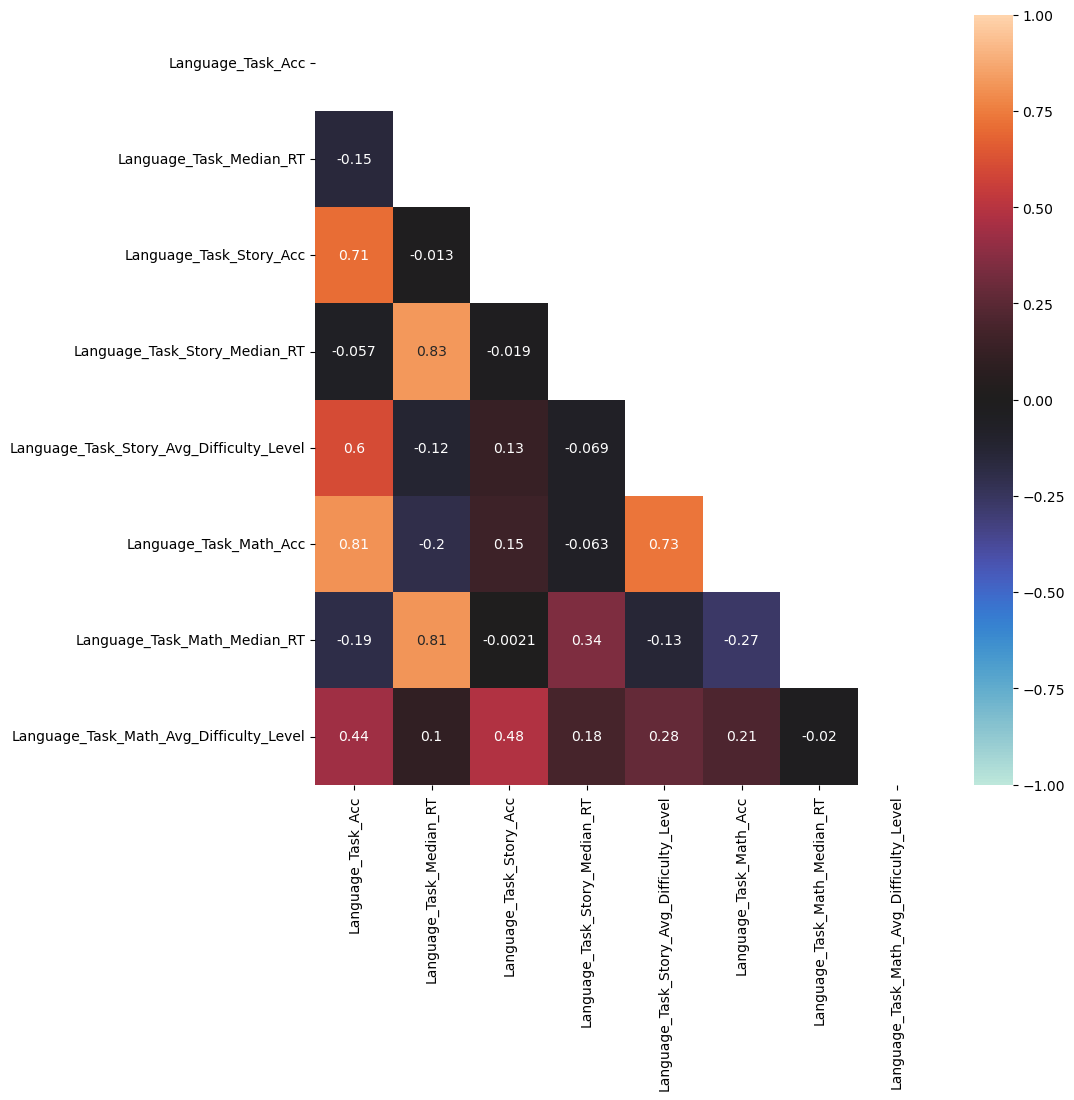

In [11]:
c=short_df.loc[:,'Language_Task_Acc':'Language_Task_Math_Avg_Difficulty_Level'].corr()
mask = np.triu(np.ones_like(c, dtype=bool))
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(c, annot=True, vmax=1, vmin=-1, center=0, mask=mask)
plt.show()


In [12]:
#including avg accuracy and avg reaction of different test conditions
short_df.drop(columns=short_df.loc[:, 'Language_Task_Story_Acc':'Language_Task_Math_Avg_Difficulty_Level'].columns, inplace=True)
print(short_df.shape)

(1206, 72)


Variable Short Penn Line Orientation task:

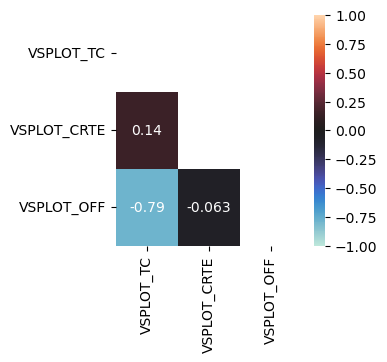

In [13]:
c=short_df.loc[:,'VSPLOT_TC':'VSPLOT_OFF'].corr()
mask = np.triu(np.ones_like(c, dtype=bool))
f, ax = plt.subplots(figsize=(3,3))
sns.heatmap(c, annot=True, vmax=1, vmin=-1, center=0, mask=mask)
plt.show()

In [14]:
#excluding the total number of correct responses of the Variable Short Penn Line Orientation task (VSPLOT_TC)
#The VSPLOT is a visual task where the participant has to match the orientation of a line shown on the screen. 
#The number of positions off is thus a more fine-grained measurement and what we will add as the accuracy score for the VSPLOT.
short_df.drop('VSPLOT_TC',axis=1, inplace=True)
print(short_df.shape)

(1206, 71)


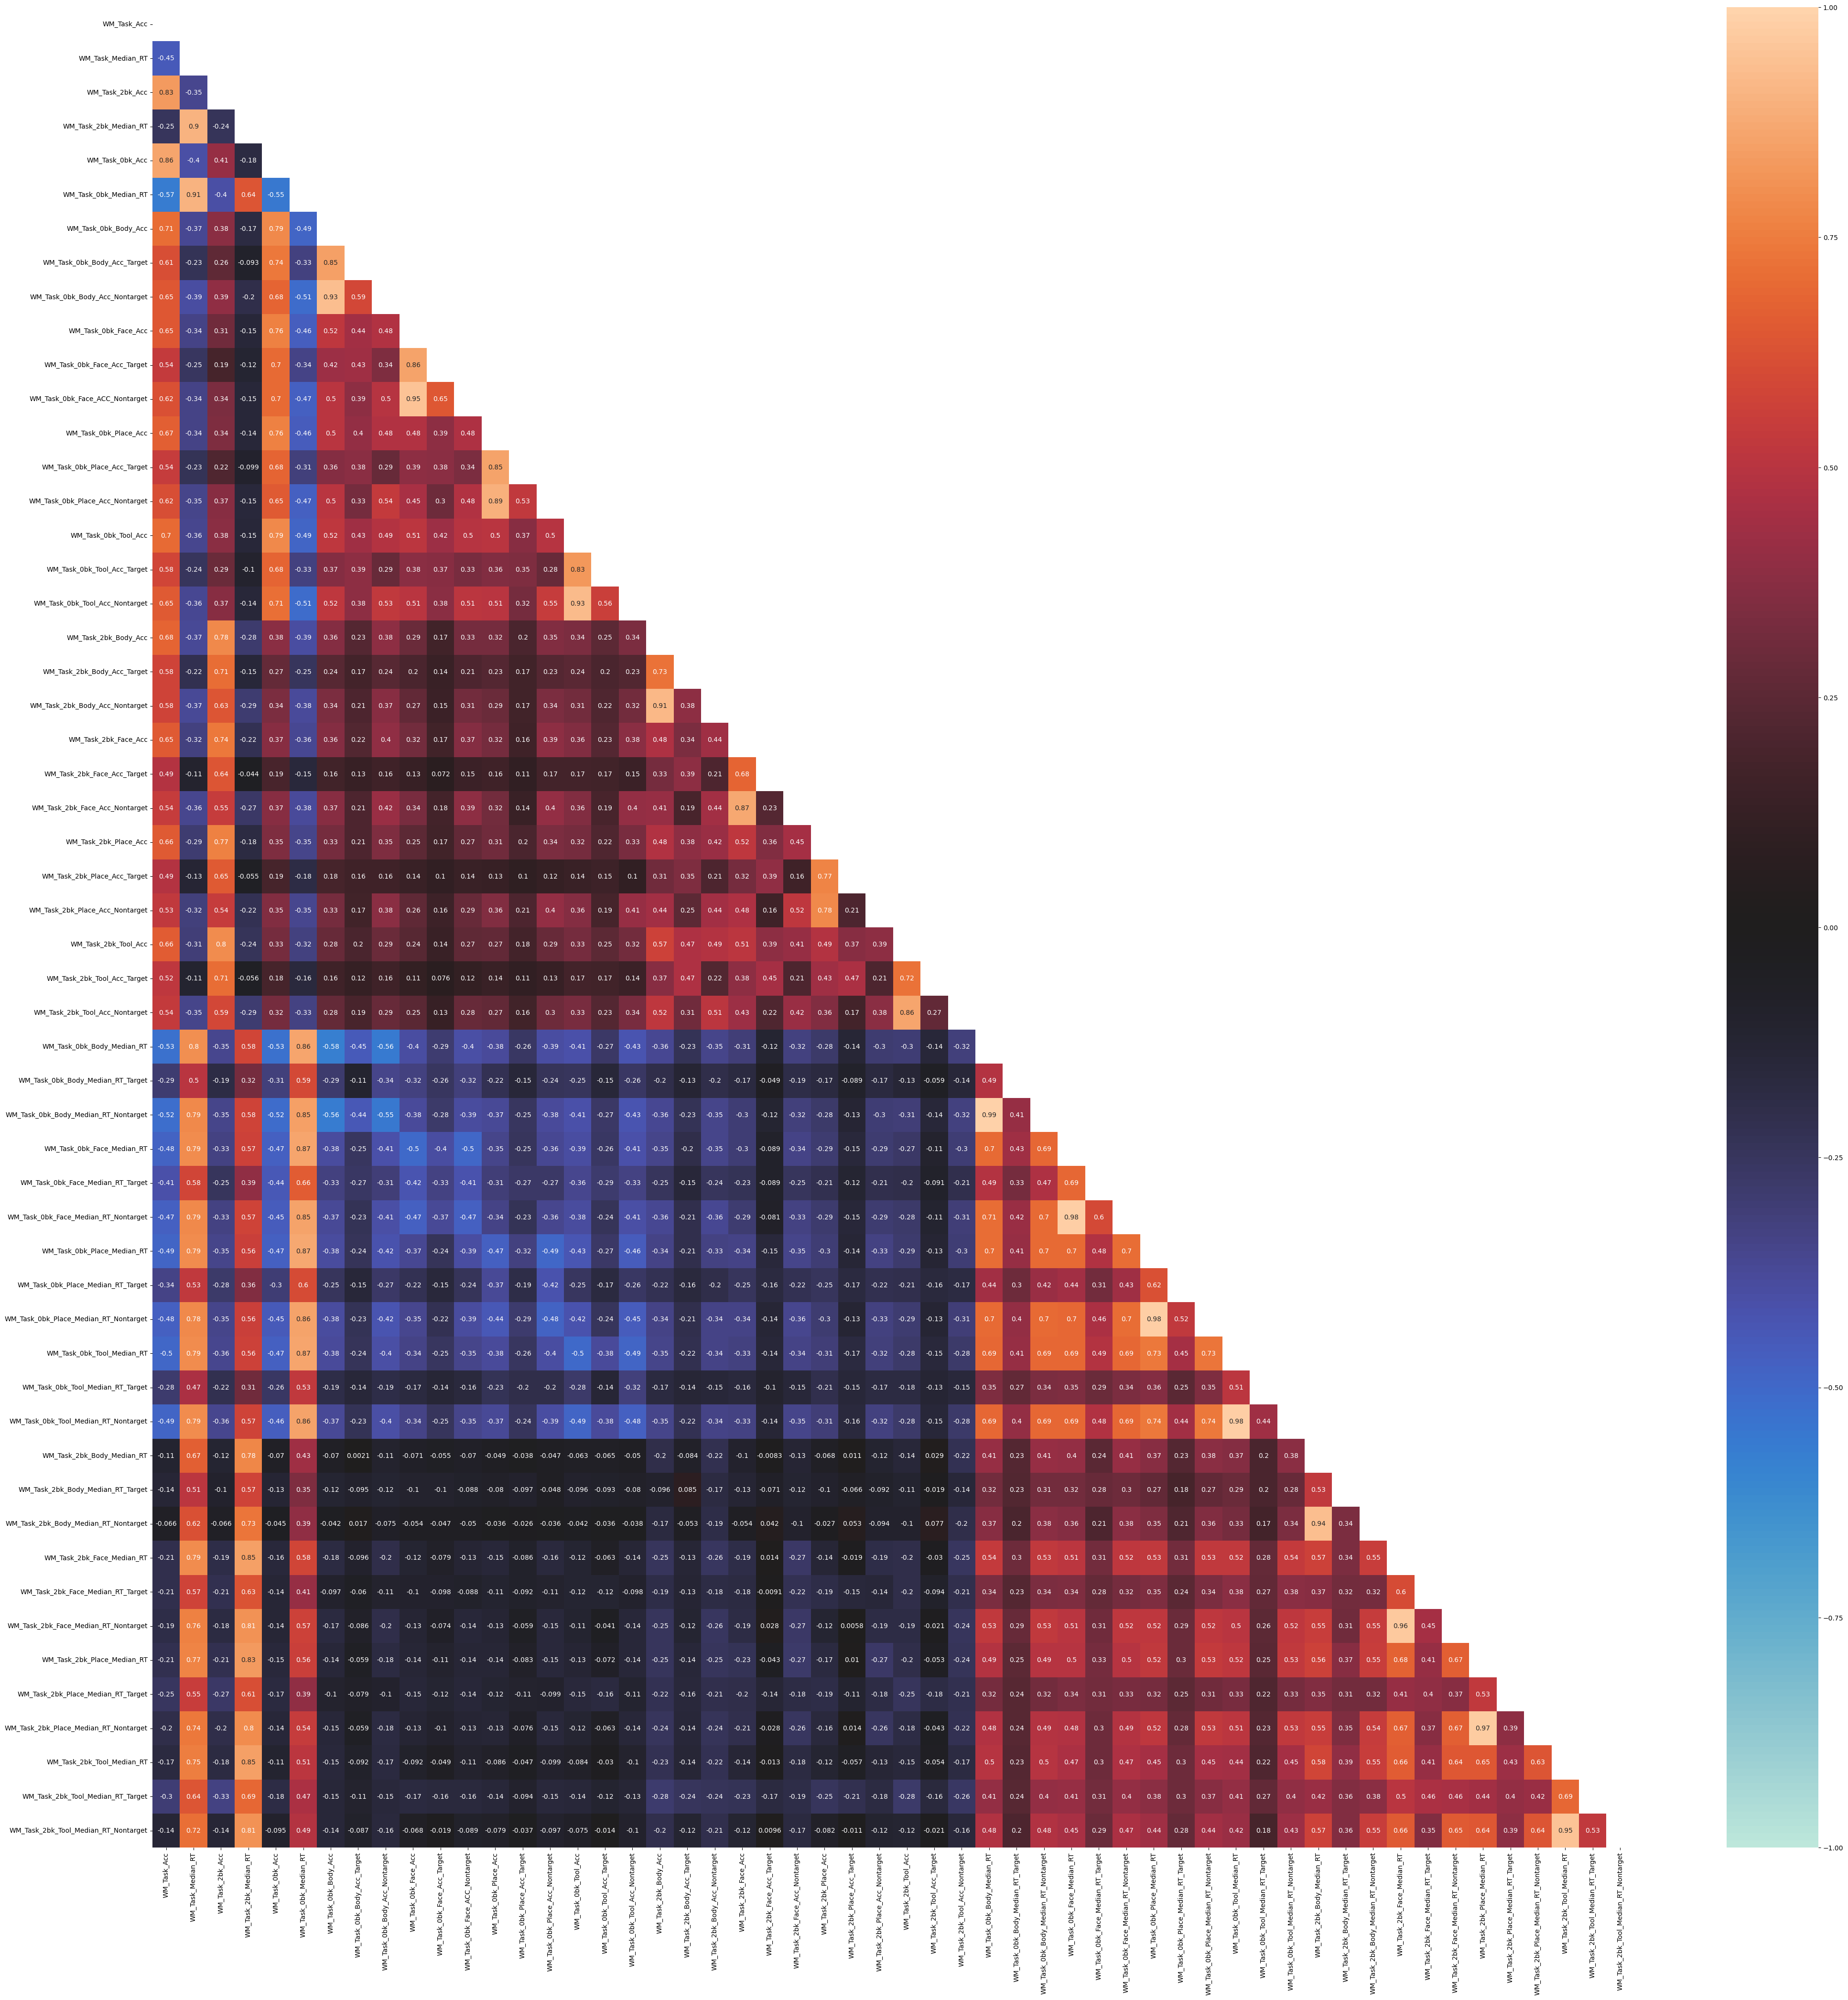

In [15]:
c=short_df.loc[:,'WM_Task_Acc':'WM_Task_2bk_Tool_Median_RT_Nontarget'].corr()
mask = np.triu(np.ones_like(c, dtype=bool))
f, ax = plt.subplots(figsize=(50,50))
sns.heatmap(c, annot=True, vmax=1, vmin=-1, center=0, mask=mask)
plt.show()

In [16]:
#including avg accuracy and avg reaction time of the different task conditions only
short_df.drop(columns=short_df.loc[:, 'WM_Task_2bk_Acc':'WM_Task_2bk_Tool_Median_RT_Nontarget'].columns, inplace=True)
print(short_df.shape)

(1206, 19)


In [17]:
#replacing NaN values
short_df_= NaN_rep(short_df)

Number of missing value from each variable:
PicSeq_Unadj                 1
CardSort_Unadj               3
Flanker_Unadj                0
PMAT24_A_CR                  9
ReadEng_Unadj                0
PicVocab_Unadj               0
ProcSpeed_Unadj              0
VSPLOT_CRTE                  9
VSPLOT_OFF                   8
SCPT_TPRT                   12
SCPT_SEN                     8
SCPT_SPEC                    8
IWRD_TOT                     8
IWRD_RTC                     8
ListSort_Unadj               0
Language_Task_Acc          152
Language_Task_Median_RT    152
WM_Task_Acc                115
WM_Task_Median_RT          131
dtype: int64


In [18]:
#inversing all rection time scores so that higher values indicate better performance
short_df_=RT_invert(short_df_)

Index(['VSPLOT_CRTE', 'VSPLOT_OFF', 'SCPT_TPRT', 'IWRD_RTC',
       'Language_Task_Median_RT', 'WM_Task_Median_RT'],
      dtype='object')


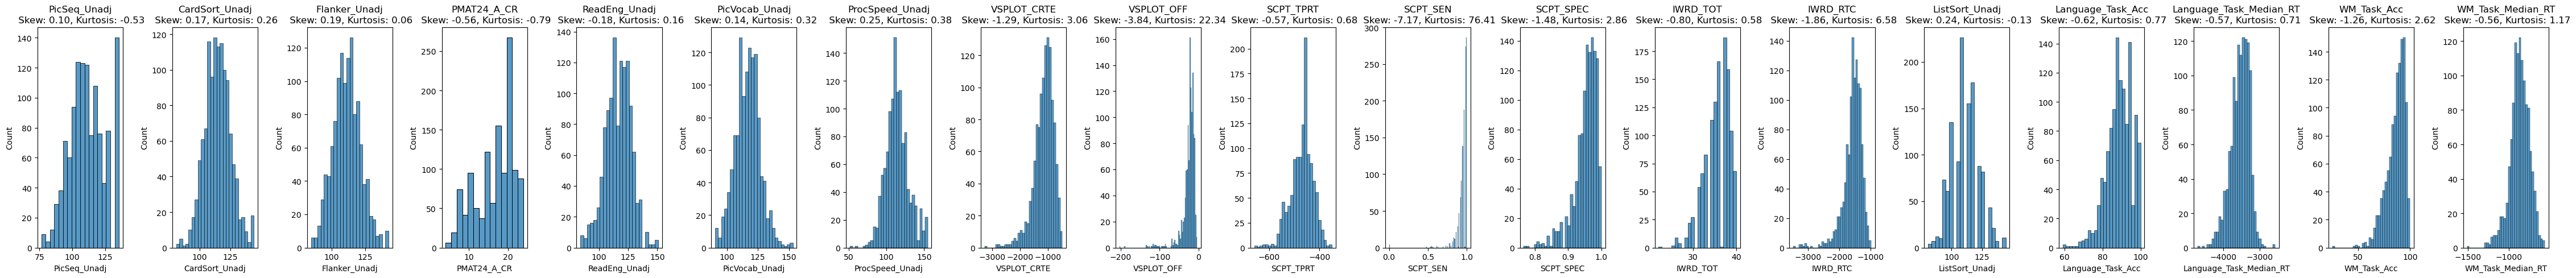

['VSPLOT_OFF', 'SCPT_SEN']
['VSPLOT_OFF', 'SCPT_SEN']


In [19]:
high_skew_cols, high_kurt_cols= plot_dist(short_df_)
print(high_skew_cols)
print(high_kurt_cols)

In [20]:
#reomving variables that violate the normality condition
short_df_.drop(columns=short_df_.loc[:, ['VSPLOT_OFF', 'SCPT_SEN']].columns, inplace=True)
print(short_df_.shape)

(1206, 17)


In [21]:
# add the demographics columns to split the data equally according to age and gender 
df_demo = pd.concat([ttl.loc[short_df_.index, ['Gender', 'Age', 'Subject']], short_df_], axis=1)

# Splitting the data:

In [22]:
train_df,test_df= split(df_demo)

In [23]:
print(train_df.shape)
print(test_df.shape)

(601, 20)
(605, 20)


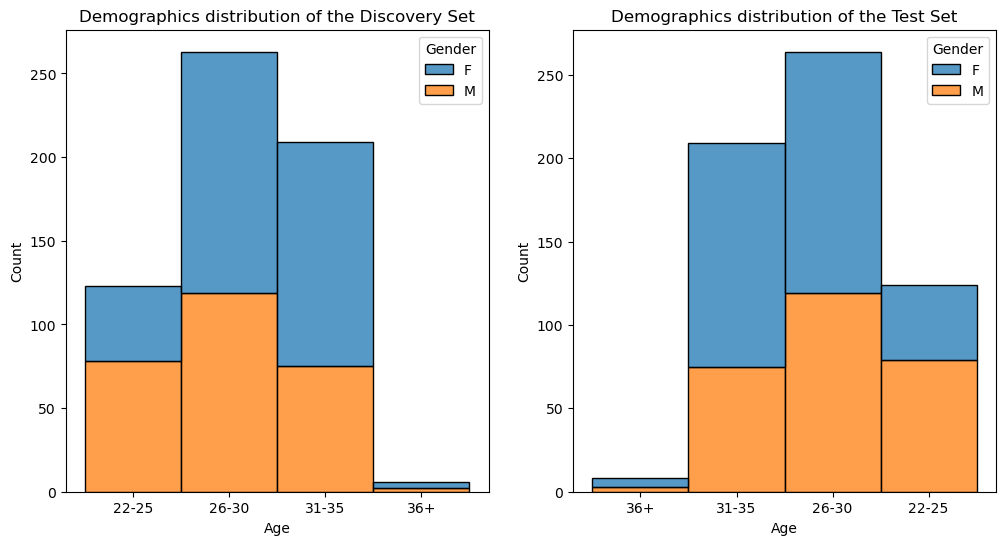

In [24]:
#plot distribution of data

fig, axs = plt.subplots(ncols=2, figsize=(12,6))

sns.histplot(train_df, x="Age", hue="Gender", multiple="stack", ax=axs[0])
axs[0].set_xlabel("Age")
axs[0].set_ylabel("Count")
axs[0].set_title("Demographics distribution of the Discovery Set")

# Plotting the second histogram with labels
sns.histplot(test_df, x="Age", hue="Gender", multiple="stack", ax=axs[1])
axs[1].set_xlabel("Age")
axs[1].set_ylabel("Count")
axs[1].set_title("Demographics distribution of the Test Set")

plt.show()


# 

# Training Data_EFA:

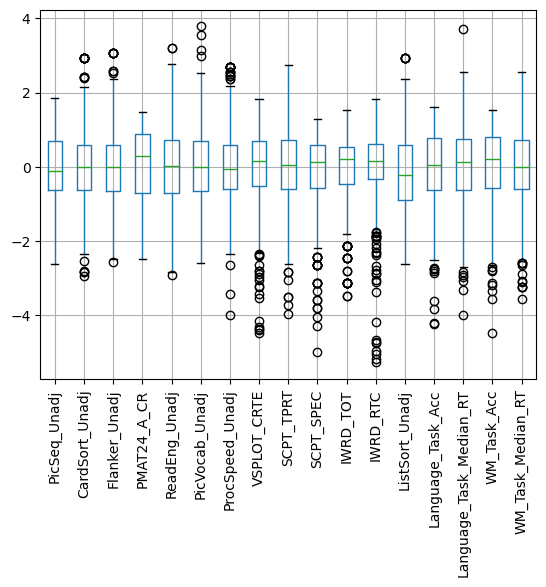

In [25]:
#normalization
df_norm= Z_Score(train_df.iloc[:,3:],True)

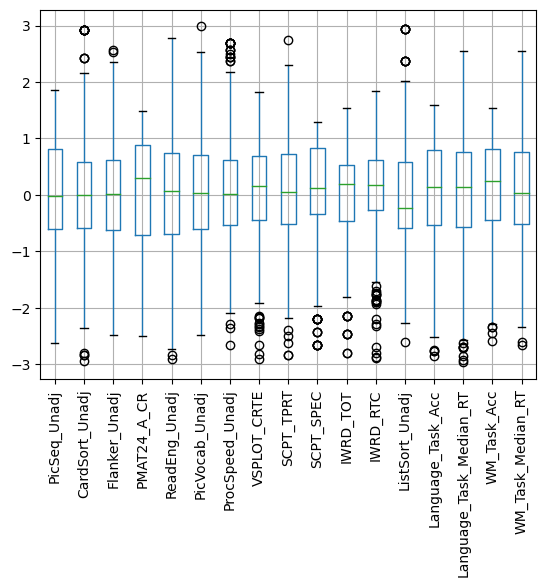

In [26]:
#removing outliers
df_clean=outliers_filter(df_norm,plot=True,threshold=3)

In [27]:
#Variance inflation factor (checking for multicolinearity):
VIF=calculate_vif(df_clean)
print(VIF)

                    Feature       VIF
0              PicSeq_Unadj  1.296387
1            CardSort_Unadj  1.680846
2             Flanker_Unadj  1.520319
3               PMAT24_A_CR  1.583027
4             ReadEng_Unadj  2.290531
5            PicVocab_Unadj  2.304492
6           ProcSpeed_Unadj  1.452037
7               VSPLOT_CRTE  1.185672
8                 SCPT_TPRT  1.191338
9                 SCPT_SPEC  1.169191
10                 IWRD_TOT  1.212845
11                 IWRD_RTC  1.450365
12           ListSort_Unadj  1.368054
13        Language_Task_Acc  1.444746
14  Language_Task_Median_RT  1.139429
15              WM_Task_Acc  1.870646
16        WM_Task_Median_RT  1.612248


In [28]:
#removing the effects of age and gender
age = train_df["Age"]
age=age[df_clean.index]
 
gender=train_df["Gender"]
gender=gender[df_clean.index]

age_ranges = ['22-25','26-30', '31-35', '36+']
age_values = [23.5, 28, 33, 36] #median value
age = age.replace(age_ranges, age_values)

gender[gender == 'M'] = 0.0
gender[gender == 'F'] = 1.0

x=pd.concat([age,gender], axis=1)

data_res_train=regress_demo(x,df_clean)

0.019006671619271245



Kaiser–Meyer–Olkin (KMO) test: is a statistical measure to determine how suited data is for factor analysis. 
#KMO test should be above 0.7

Bartlett’s test of sphericity examines whether a correlation matrix is significantly different to the identity matrix, 
in which diagonal elements are unities and all off-diagonal elements are zeros (Bartlett, 1950). 
Significant results indicate that variables in the correlation matrix are suitable for factor analysis.


In [29]:
test_factorability(data_res_train)

Kaiser-Meyer-Olkin (KMO) Test:
0.7981437164639283
Bartlett's test of sphericity:
Chi-square: 2131.4689505706347
P-value: 0.0


In [30]:
#determining the ideal number of factrs using parallel analysis
num_factors=parallel_analysis(data_res_train, k=20, method="ml", return_ev=False)
print(num_factors)

3


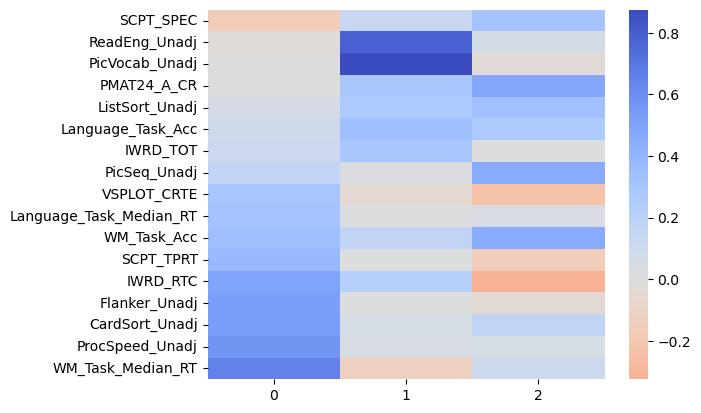

In [31]:
train_fa=efa_analysis(data_res_train,num_factors, 'ml', 'oblimin', 'train_ml_oblimin', False)
train_fa.fit(data_res_train)
train_loadings=train_fa.loadings_
visualize_loadings(train_loadings,data_res_train.columns,ordered=True,save = True)

Internal consistency (Croncach alpha):

In [32]:
import pingouin as pg
 

# Factor 1: Processing Speed
#speed based measures and cognitive tasks that require quick processing of stimuli
factor1=data_res_train[['CardSort_Unadj' , 'Flanker_Unadj','ProcSpeed_Unadj','VSPLOT_CRTE','SCPT_TPRT', 'IWRD_RTC','Language_Task_Median_RT','WM_Task_Median_RT']]

# Factor 2: Language abilities
#reading, vocaabulary and comprehension 
factor2 = data_res_train[['ReadEng_Unadj' , 'PicVocab_Unadj' , 'Language_Task_Acc']]

# Factor 3: Cognitive flexibility
#episodic and working memory, cognitive flexibility and attention
factor3=data_res_train[[ 'PicSeq_Unadj','ListSort_Unadj','WM_Task_Acc' , 'PMAT24_A_CR' , 'SCPT_SPEC']]

#Get cronbach alpha
factor1_alpha = pg.cronbach_alpha(factor1)
factor2_alpha = pg.cronbach_alpha(factor2)
factor3_alpha = pg.cronbach_alpha(factor3)

print('f1:',factor1_alpha,'f2: ', factor2_alpha,'f3: ', factor3_alpha)

f1: (0.6823088347950276, array([0.64 , 0.722])) f2:  (0.7590647095152707, array([0.721, 0.793])) f3:  (0.6631108653633176, array([0.616, 0.706]))


# 

# Test Data_CFA:

Confirming the latent structure from EFA using an independent dataset

In [33]:
df_norm_test= Z_Score(test_df.iloc[:,3:],False)
#removing outliers
df_clean_test=outliers_filter(df_norm_test,plot=False,threshold=3)

In [34]:
#regressing out age and gender
age = test_df["Age"]
age=age[df_clean_test.index]
 
gender=test_df["Gender"]
gender=gender[df_clean_test.index]

age_ranges = ['22-25','26-30', '31-35', '36+']
age_values = [23.5, 28, 33, 36] #median value
age = age.replace(age_ranges, age_values)

    #gender = df_main.iloc[data.index,3 ].copy()#Gender
gender[gender == 'M'] = 0.0
gender[gender == 'F'] = 1.0

x=pd.concat([age,gender], axis=1)
data_res_test=regress_demo(x,df_clean_test)

0.020025493327583594


In [35]:
test_factorability(data_res_test)

Kaiser-Meyer-Olkin (KMO) Test:
0.7827991332941447
Bartlett's test of sphericity:
Chi-square: 2009.0679981438225
P-value: 0.0


In [36]:
from factor_analyzer import (ConfirmatoryFactorAnalyzer, ModelSpecificationParser)
alt=data_res_test.drop(['IWRD_TOT'],axis=1) #word memory accuracy task did not load on any of the factors significantly (<0.3)
model_dict={"F1":['CardSort_Unadj' , 'Flanker_Unadj','ProcSpeed_Unadj','VSPLOT_CRTE','SCPT_TPRT', 'IWRD_RTC','Language_Task_Median_RT','WM_Task_Median_RT'],
            "F2":['ReadEng_Unadj' , 'PicVocab_Unadj' , 'Language_Task_Acc'],
            "F3":[ 'PicSeq_Unadj' , 'PMAT24_A_CR' , 'SCPT_SPEC','ListSort_Unadj','WM_Task_Acc']}
model_spec = ModelSpecificationParser.parse_model_specification_from_dict(alt,
                                                                           model_dict)

cfa = ConfirmatoryFactorAnalyzer(model_spec, disp=True)

cfa.fit(alt.values)

cfa.loadings_


C:\Users\olah4\anaconda3\lib\site-packages\factor_analyzer\confirmatory_factor_analyzer.py:753: UserWarning: The optimization routine failed to converge: ABNORMAL_TERMINATION_IN_LNSRCH
  warnings.warn(


array([[0.72477959, 0.        , 0.        ],
       [0.8879358 , 0.        , 0.        ],
       [0.86689143, 0.        , 0.        ],
       [0.872766  , 0.        , 0.        ],
       [0.99163678, 0.        , 0.        ],
       [0.9103547 , 0.        , 0.        ],
       [0.83472141, 0.        , 0.        ],
       [0.34979799, 0.        , 0.        ],
       [0.        , 0.65226535, 0.        ],
       [0.        , 0.30645252, 0.        ],
       [0.        , 0.66031553, 0.        ],
       [0.        , 0.        , 0.75180361],
       [0.        , 0.        , 0.6887866 ],
       [0.        , 0.        , 0.60220876],
       [0.        , 0.        , 0.81822214],
       [0.        , 0.        , 0.72116887]])

In [37]:
with pd.ExcelWriter('data_res_test.xlsx', mode="w") as writer:
    alt.to_excel(writer, sheet_name='data_res_test', index=True)